# Drug Release Model

This notebook implements a drug release model solving three PDEs for `u` (unbound drug), `v` (bound drug), and `s` (stress) using the Method of Lines (MOL). Two ODE routines are provided:
- `drug_1`: Uses stagewise differentiation (two calls to `dss004` for second derivatives).
- `drug_2`: Uses direct second derivative computation (`dss044`).

The model tests parameter variations for `E` (0.2 and -0.2) to study stress effects. Outputs include numerical tables and plots:
- `ip=1`: Plots `u`, `v`, `s` vs. `x` at `t=0, 0.4, ..., 2` with markers (Figs. 7.7–7.9).
- `ip=2`: Plots `u`, `v`, `s` vs. `t` at `x=0` (Figs. 7.4–7.6).

The code is adapted from Listings 7.1–7.5, with comments for clarity.

In [16]:
# Import required libraries
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Placeholder for dss004 (finite difference for first derivative)
def dss004(xl, xu, nx, u):
    """
    Computes first derivative using finite difference (placeholder).
    Inputs: xl, xu (lower, upper x boundaries), nx (number of grid points), u (input array).
    Returns: du_dx (first derivative).
    Replace with actual implementation if available.
    """
    dx = (xu - xl) / (nx - 1)  # Grid spacing
    du_dx = np.zeros(nx)  # Initialize derivative array
    # Central difference for interior points
    for i in range(1, nx - 1):
        du_dx[i] = (u[i + 1] - u[i - 1]) / (2 * dx)
    # Forward/backward difference at boundaries
    du_dx[0] = (u[1] - u[0]) / dx
    du_dx[nx - 1] = (u[nx - 1] - u[nx - 2]) / dx
    return du_dx

# Placeholder for dss044 (finite difference for second derivative)
def dss044(xl, xu, nx, u, ux, nl, nu):
    """
    Computes second derivative using finite difference with Neumann BCs (nl=2, nu=2).
    Inputs: xl, xu, nx, u (input array), ux (boundary derivatives), nl, nu (BC types).
    Returns: d2u_dx2 (second derivative).
    Replace with actual implementation if available.
    """
    dx = (xu - xl) / (nx - 1)  # Grid spacing
    d2u_dx2 = np.zeros(nx)  # Initialize second derivative array
    # Central difference for interior points
    for i in range(1, nx - 1):
        d2u_dx2[i] = (u[i + 1] - 2 * u[i] + u[i - 1]) / (dx ** 2)
    # Neumann BCs at boundaries using ux
    d2u_dx2[0] = (2 * u[1] - 2 * u[0] - 2 * dx * ux[0]) / (dx ** 2)
    d2u_dx2[nx - 1] = (2 * u[nx - 2] - 2 * u[nx - 1] + 2 * dx * ux[nx - 1]) / (dx ** 2)
    return d2u_dx2

# Reaction terms
def f_u(ub, vb, u, v):
    """
    Computes the rate of binding/unbinding for u (unbound drug).
    Inputs: ub, vb (reference concentrations), u, v (current concentrations).
    Returns: Rate of change for u.
    """
    return -u * (ub - u) + v * (vb - v)

def g_v(ub, vb, u, v):
    """
    Computes the rate of binding/unbinding for v (bound drug).
    Inputs: ub, vb (reference concentrations), u, v (current concentrations).
    Returns: Rate of change for v.
    """
    return u * (ub - u) - v * (vb - v)

# ODE routine with stagewise differentiation
def drug_1(t, U, parms, nx, xl, xu, kr, D, ua, E, alpha, beta, gamma, ub, vb, dss004, f_u, g_v):
    """
    Computes the time derivative vector of u, v, s using stagewise differentiation.
    Inputs: t (time), U (state vector), parms (unused), and model parameters.
    Returns: Ut (time derivative vector).
    """
    # One vector to three vectors
    u = [0] * nx
    v = [0] * nx
    s = [0] * nx
    for i in range(nx):
        u[i] = U[i]
        v[i] = U[i + nx]
        s[i] = U[i + 2 * nx]

    # Compute first derivatives ux, sx
    ux = dss004(xl, xu, nx, u)
    sx = dss004(xl, xu, nx, s)

    # Boundary conditions
    ux[0] = -(kr / D) * (ua - u[0])  # Neumann BC at x=-0.5
    ux[nx - 1] = (kr / D) * (ua - u[nx - 1])  # Neumann BC at x=0.5
    sx[0] = 0  # Zero derivative at x=-0.5
    sx[nx - 1] = 0  # Zero derivative at x=0.5

    # Compute second derivatives uxx, sxx
    uxx = dss004(xl, xu, nx, ux)
    sxx = dss004(xl, xu, nx, sx)

    # PDEs
    ut = [0] * nx
    vt = [0] * nx
    st = [0] * nx
    for i in range(nx):
        ut[i] = D * uxx[i] + E * sxx[i] + f_u(ub, vb, u[i], v[i])  # Eq. (7.1a)
        vt[i] = g_v(ub, vb, u[i], v[i])  # Eq. (7.1b)
        st[i] = alpha * u[i] - beta * s[i] + gamma * ut[i]  # Eq. (7.1c)

    # Three vectors to one vector
    Ut = [0] * (3 * nx)
    for i in range(nx):
        Ut[i] = ut[i]
        Ut[i + nx] = vt[i]
        Ut[i + 2 * nx] = st[i]

    # Increment calls to drug_1
    global ncall
    ncall += 1

    # Return derivative vector
    return Ut

# ODE routine with direct second derivative
def drug_2(t, U, parms, nx, xl, xu, kr, D, ua, E, alpha, beta, gamma, ub, vb, dss044, f_u, g_v):
    """
    Computes the time derivative vector of u, v, s using direct second derivative.
    Inputs: t (time), U (state vector), parms (unused), and model parameters.
    Returns: Ut (time derivative vector).
    """
    # One vector to three vectors
    u = [0] * nx
    v = [0] * nx
    s = [0] * nx
    for i in range(nx):
        u[i] = U[i]
        v[i] = U[i + nx]
        s[i] = U[i + 2 * nx]

    # Boundary conditions
    ux = [0] * nx
    sx = [0] * nx
    ux[0] = -(kr / D) * (ua - u[0])  # Neumann BC at x=-0.5
    ux[nx - 1] = (kr / D) * (ua - u[nx - 1])  # Neumann BC at x=0.5
    sx[0] = 0  # Zero derivative at x=-0.5
    sx[nx - 1] = 0  # Zero derivative at x=0.5

    # Compute second derivatives uxx, sxx
    nl = 2  # Neumann BCs
    nu = 2
    uxx = dss044(xl, xu, nx, u, ux, nl, nu)
    sxx = dss044(xl, xu, nx, s, sx, nl, nu)

    # PDEs
    ut = [0] * nx
    vt = [0] * nx
    st = [0] * nx
    for i in range(nx):
        ut[i] = D * uxx[i] + E * sxx[i] + f_u(ub, vb, u[i], v[i])  # Eq. (7.1a)
        vt[i] = g_v(ub, vb, u[i], v[i])  # Eq. (7.1b)
        st[i] = alpha * u[i] - beta * s[i] + gamma * ut[i]  # Eq. (7.1c)

    # Three vectors to one vector
    Ut = [0] * (3 * nx)
    for i in range(nx):
        Ut[i] = ut[i]
        Ut[i + nx] = vt[i]
        Ut[i + 2 * nx] = st[i]

    # Increment calls to drug_2
    global ncall
    ncall += 1

    # Return derivative vector
    return Ut

*** The Main Program to control ip and ncase***

In [17]:
# Main program

# Initialize global call counter
ncall = 0

# Format of output
ip = 1 # ip=1: Plot vs x with t as parameter; ip=2: Plot vs t at x=0

# Select ODE routine
ncase = 2  # ncase=1: drug_1 (stagewise); ncase=2: drug_2 (direct)

# Grid in x
nx = 26  # Number of spatial grid points
xl = -0.5  # Lower boundary
xu = 0.5  # Upper boundary
xg = np.linspace(xl, xu, nx)  # Spatial grid

# Grid in t
if ip == 1:
    nout = 6  # Number of output times
    t0 = 0  # Initial time
    tf = 2  # Final time
elif ip == 2:
    nout = 41  # Number of output times
    t0 = 0  # Initial time
    tf = 2  # Final time
tout = np.linspace(t0, tf, nout)  # Temporal grid

# Parameters (base case and variation)
cases = [
    {"E": 0.2, "label": "Base Case (E=0.2)"},
    {"E": -0.2, "label": "Variation (E=-0.2)"}
]
alpha = 0.2  # Stress coupling coefficient
beta = 1  # Stress decay coefficient
gamma = 1  # Stress response coefficient
D = 0.6  # Diffusion coefficient
kr = 1  # Boundary mass transfer coefficient
ub = 1  # Reference concentration for u
vb = 1  # Reference concentration for v
ua = 0  # Boundary concentration for u

In [18]:
# Simulation and numerical output

# Loop over parameter cases
for case in cases:
    E = case["E"]  # Stress coupling parameter
    print(f"\n=== {case['label']} ===\n")
    print(f"D = {D:.3f}  E = {E:.3f}\n")

    # Initial conditions
    u0 = np.zeros(3 * nx)  # Initialize state vector
    for ix in range(nx):
        u0[ix] = 0.75  # u(x,0) = 0.75
        u0[ix + nx] = 0.25  # v(x,0) = 0.25
        u0[ix + 2 * nx] = 0  # s(x,0) = 0

    # Reset call counter
    ncall = 0

    # ODE integration
    if ncase == 1:
        out = odeint(lambda U, t: drug_1(t, U, None, nx, xl, xu, kr, D, ua, E, alpha, beta, gamma, ub, vb, dss004, f_u, g_v), u0, tout)  # Solve with drug_1
    elif ncase == 2:
        out = odeint(lambda U, t: drug_2(t, U, None, nx, xl, xu, kr, D, ua, E, alpha, beta, gamma, ub, vb, dss044, f_u, g_v), u0, tout)  # Solve with drug_2

    # Arrays for plotting numerical solutions
    u_xplot = np.zeros((nx, nout))  # Array for u(x,t)
    v_xplot = np.zeros((nx, nout))  # Array for v(x,t)
    s_xplot = np.zeros((nx, nout))  # Array for s(x,t)
    for it in range(nout):
        for ix in range(nx):
            u_xplot[ix, it] = out[it, ix]  # Extract u
            v_xplot[ix, it] = out[it, ix + nx]  # Extract v
            s_xplot[ix, it] = out[it, ix + 2 * nx]  # Extract s

    # Display numerical solutions for t = 0, 2
    if ip == 1:
        for it in [0, nout - 1]:  # t = 0, 2
            print(f"\n\nt       x        u(x,t)      v(x,t)      s(x,t)")
            for ix in range(nx):
                print(f"{tout[it]:6.1f} {xg[ix]:7.2f} {u_xplot[ix, it]:12.5f} {v_xplot[ix, it]:12.5f} {s_xplot[ix, it]:12.5f}")
    elif ip == 2:
        for it in [0, nout - 1]:  # t = 0, 2
            print(f"\n\nt       x        u(x,t)      v(x,t)      s(x,t)")
            for ix in range(nx):
                print(f"{tout[it]:6.1f} {xg[ix]:7.2f} {u_xplot[ix, it]:12.5f} {v_xplot[ix, it]:12.5f} {s_xplot[ix, it]:12.5f}")

    # Display number of calls
    print(f"\n\nncall = {ncall}\n")


=== Base Case (E=0.2) ===

D = 0.600  E = 0.200



t       x        u(x,t)      v(x,t)      s(x,t)
   0.0   -0.50      0.75000      0.25000      0.00000
   0.0   -0.46      0.75000      0.25000      0.00000
   0.0   -0.42      0.75000      0.25000      0.00000
   0.0   -0.38      0.75000      0.25000      0.00000
   0.0   -0.34      0.75000      0.25000      0.00000
   0.0   -0.30      0.75000      0.25000      0.00000
   0.0   -0.26      0.75000      0.25000      0.00000
   0.0   -0.22      0.75000      0.25000      0.00000
   0.0   -0.18      0.75000      0.25000      0.00000
   0.0   -0.14      0.75000      0.25000      0.00000
   0.0   -0.10      0.75000      0.25000      0.00000
   0.0   -0.06      0.75000      0.25000      0.00000
   0.0   -0.02      0.75000      0.25000      0.00000
   0.0    0.02      0.75000      0.25000      0.00000
   0.0    0.06      0.75000      0.25000      0.00000
   0.0    0.10      0.75000      0.25000      0.00000
   0.0    0.14      0.75000      0.2

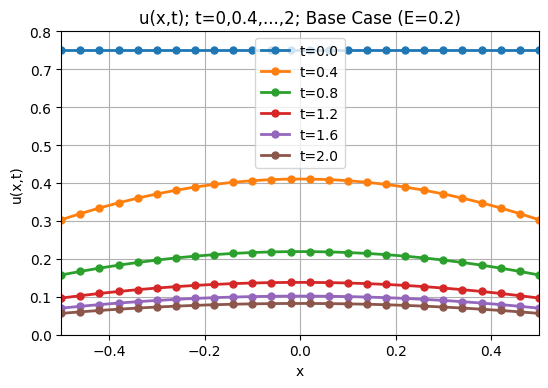

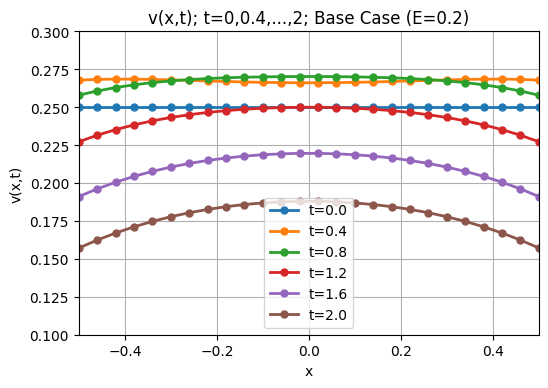

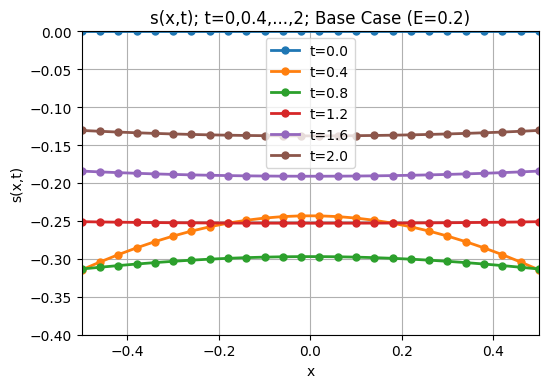

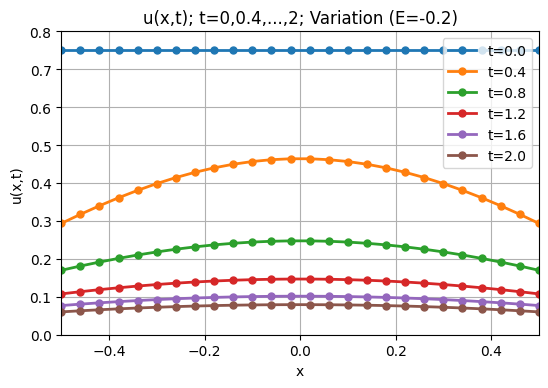

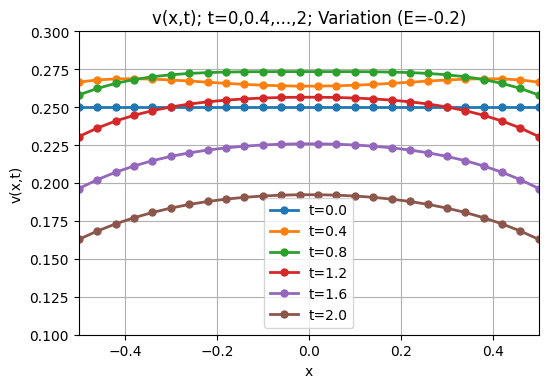

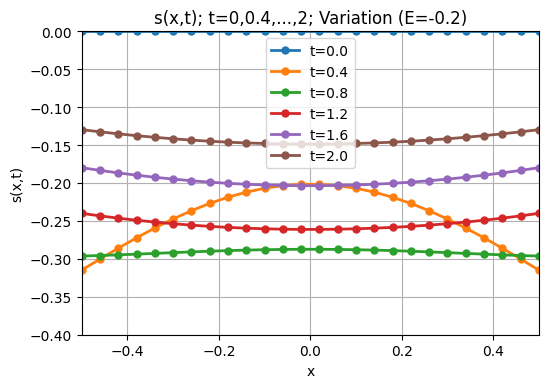

In [19]:
# Plotting numerical solutions

# Loop over parameter cases
for case in cases:
    E = case["E"]  # Stress coupling parameter

    # Re-run ODE integration for plotting
    ncall = 0
    if ncase == 1:
        out = odeint(lambda U, t: drug_1(t, U, None, nx, xl, xu, kr, D, ua, E, alpha, beta, gamma, ub, vb, dss004, f_u, g_v), u0, tout)  # Solve with drug_1
    elif ncase == 2:
        out = odeint(lambda U, t: drug_2(t, U, None, nx, xl, xu, kr, D, ua, E, alpha, beta, gamma, ub, vb, dss044, f_u, g_v), u0, tout)  # Solve with drug_2

    # Arrays for plotting
    u_xplot = np.zeros((nx, nout))  # Array for u(x,t)
    v_xplot = np.zeros((nx, nout))  # Array for v(x,t)
    s_xplot = np.zeros((nx, nout))  # Array for s(x,t)
    for it in range(nout):
        for ix in range(nx):
            u_xplot[ix, it] = out[it, ix]  # Extract u
            v_xplot[ix, it] = out[it, ix + nx]  # Extract v
            s_xplot[ix, it] = out[it, ix + 2 * nx]  # Extract s

    # Plot u, v, s vs x with t as parameter (t = 0, 0.4, ..., 2)
    if ip == 1:
        # Plot u(x,t)
        plt.figure()
        plt.plot(xg, u_xplot[:, 0], 'o-', label="t=0.0", linewidth=2, markersize=5)  # t=0
        for it in range(1, nout):
            plt.plot(xg, u_xplot[:, it], 'o-', label=f"t={tout[it]:.1f}", linewidth=2, markersize=5)  # t=0.4,0.8,...,2
        plt.xlabel("x")  # x-axis label
        plt.ylabel("u(x,t)")  # y-axis label
        plt.title(f"u(x,t); t=0,0.4,...,2; {case['label']}")  # Title
        plt.xlim([xl, xu])  # x-axis limits
        plt.ylim([0, 0.8])  # y-axis limits for u
        plt.legend()  # Show legend
        plt.grid(True)  # Show grid
        plt.tight_layout(pad=4.0)


        # Plot v(x,t)
        plt.figure()
        plt.plot(xg, v_xplot[:, 0], 'o-', label="t=0.0", linewidth=2, markersize=5)  # t=0
        for it in range(1, nout):
            plt.plot(xg, v_xplot[:, it], 'o-', label=f"t={tout[it]:.1f}", linewidth=2, markersize=5)  # t=0.4,0.8,...,2
        plt.xlabel("x")  # x-axis label
        plt.ylabel("v(x,t)")  # y-axis label
        plt.title(f"v(x,t); t=0,0.4,...,2; {case['label']}")  # Title
        plt.xlim([xl, xu])  # x-axis limits
        plt.ylim([0.1, 0.3])  # y-axis limits for v
        plt.legend()  # Show legend
        plt.grid(True)  # Show grid
        plt.tight_layout(pad=4.0)


        # Plot s(x,t)
        plt.figure()
        plt.plot(xg, s_xplot[:, 0], 'o-', label="t=0.0", linewidth=2, markersize=5)  # t=0
        for it in range(1, nout):
            plt.plot(xg, s_xplot[:, it], 'o-', label=f"t={tout[it]:.1f}", linewidth=2, markersize=5)  # t=0.4,0.8,...,2
        plt.xlabel("x")  # x-axis label
        plt.ylabel("s(x,t)")  # y-axis label
        plt.title(f"s(x,t); t=0,0.4,...,2; {case['label']}")  # Title
        plt.xlim([xl, xu])  # x-axis limits
        plt.ylim([-0.4, 0.0])  # y-axis limits for s
        plt.legend()  # Show legend
        plt.grid(True)  # Show grid
        plt.tight_layout(pad=4.0)


        plt.show()  # Display plots

    # Plot u, v, s vs t at x=0
    elif ip == 2:
        u_tplot = u_xplot[12, :]  # u at x=0 (index 12 for nx=26)
        v_tplot = v_xplot[12, :]  # v at x=0
        s_tplot = s_xplot[12, :]  # s at x=0

        plt.figure()
        plt.plot(tout, u_tplot, label="u(x=0,t)")  # Plot u vs t
        plt.xlabel("t")  # x-axis label
        plt.ylabel("u(x,t), x=0")  # y-axis label
        plt.title(f"u(x,t); x=0; {case['label']}")  # Title
        plt.xlim([t0, tf])  # x-axis limits
        plt.legend()  # Show legend
        plt.grid(True)  # Show grid
        plt.tight_layout(pad=4.0)


        plt.figure()
        plt.plot(tout, v_tplot, label="v(x=0,t)")  # Plot v vs t
        plt.xlabel("t")  # x-axis label
        plt.ylabel("v(x,t), x=0")  # y-axis label
        plt.title(f"v(x,t); x=0; {case['label']}")  # Title
        plt.xlim([t0, tf])  # x-axis limits
        plt.legend()  # Show legend
        plt.grid(True)  # Show grid
        plt.tight_layout(pad=4.0)


        plt.figure()
        plt.plot(tout, s_tplot, label="s(x=0,t)")  # Plot s vs t
        plt.xlabel("t")  # x-axis label
        plt.ylabel("s(x,t), x=0")  # y-axis label
        plt.title(f"s(x,t); x=0; {case['label']}")  # Title
        plt.xlim([t0, tf])  # x-axis limits
        plt.legend()  # Show legend
        plt.grid(True)  # Show grid
        plt.tight_layout(pad=4)
           # plt.legend().set_visible(False)


        plt.show()  # Display plots